# Coral Bleach Detection - Exploratory Data Analysis

This notebook performs comprehensive EDA on the coral bleaching dataset to understand:
- Dataset structure and composition
- Bleaching patterns and severity distribution
- Image characteristics and mask quality
- Feature engineering opportunities for model development

## 1. Data Overview & Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import glob
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Set figure sizes
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Define data paths
DATA_DIR = Path('../data')
IMAGES_DIR = DATA_DIR / 'images'
BLEACHED_MASKS_DIR = DATA_DIR / 'masks_bleached'
NON_BLEACHED_MASKS_DIR = DATA_DIR / 'masks_non_bleached'

# Verify directories exist
for dir_path in [IMAGES_DIR, BLEACHED_MASKS_DIR, NON_BLEACHED_MASKS_DIR]:
    if not dir_path.exists():
        print(f"Warning: {dir_path} does not exist!")
    else:
        print(f"✓ {dir_path} found")

print(f"\nData directory structure:")
# Handle both .jpg and .JPG extensions
jpg_files = list(IMAGES_DIR.glob('*.jpg'))
JPG_files = list(IMAGES_DIR.glob('*.JPG'))
total_images = jpg_files + JPG_files
print(f"Images: {len(total_images)} files (.jpg: {len(jpg_files)}, .JPG: {len(JPG_files)})")
print(f"Bleached masks: {len(list(BLEACHED_MASKS_DIR.glob('*.png')))} files")
print(f"Non-bleached masks: {len(list(NON_BLEACHED_MASKS_DIR.glob('*.png')))} files")

✓ ../data/images found
✓ ../data/masks_bleached found
✓ ../data/masks_non_bleached found

Data directory structure:
Images: 658 files (.jpg: 512, .JPG: 146)
Bleached masks: 658 files
Non-bleached masks: 658 files


In [5]:
# Get all image files and create a mapping
# Handle both .jpg and .JPG extensions
jpg_files = sorted(list(IMAGES_DIR.glob('*.jpg')))
JPG_files = sorted(list(IMAGES_DIR.glob('*.JPG')))
image_files = jpg_files + JPG_files
print(f"Found {len(image_files)} images (.jpg: {len(jpg_files)}, .JPG: {len(JPG_files)})")

# Create mapping between original images and their masks
image_data = []

for img_path in image_files:
    base_name = img_path.stem  # filename without extension
    
    # Construct mask paths based on original filename pattern
    # For .jpg files: *_corr.jpg -> *_corr_bleached.png
    # For .JPG files: *_Corr.JPG -> *_Corr_bleached.png
    bleached_mask_path = BLEACHED_MASKS_DIR / f"{base_name}_bleached.png"
    non_bleached_mask_path = NON_BLEACHED_MASKS_DIR / f"{base_name}_non_bleached.png"
    
    image_data.append({
        'image_name': img_path.name,
        'image_path': img_path,
        'extension': img_path.suffix,
        'bleached_mask_path': bleached_mask_path,
        'non_bleached_mask_path': non_bleached_mask_path,
        'has_bleached_mask': bleached_mask_path.exists(),
        'has_non_bleached_mask': non_bleached_mask_path.exists()
    })

df = pd.DataFrame(image_data)
print(f"\nDataset overview:")
print(f"Total images: {len(df)}")
print(f"Images with bleached masks: {df['has_bleached_mask'].sum()}")
print(f"Images with non-bleached masks: {df['has_non_bleached_mask'].sum()}")
print(f"Complete triplets (image + both masks): {(df['has_bleached_mask'] & df['has_non_bleached_mask']).sum()}")

# Check breakdown by extension
print(f"\nBreakdown by file extension:")
extension_summary = df.groupby('extension').agg({
    'has_bleached_mask': 'sum',
    'has_non_bleached_mask': 'sum',
    'image_name': 'count'
}).rename(columns={'image_name': 'total_images'})
extension_summary['complete_triplets'] = (df.groupby('extension').apply(
    lambda x: ((x['has_bleached_mask'] & x['has_non_bleached_mask']).sum())
)).values
print(extension_summary)


Found 658 images (.jpg: 512, .JPG: 146)

Dataset overview:
Total images: 658
Images with bleached masks: 658
Images with non-bleached masks: 658
Complete triplets (image + both masks): 658

Breakdown by file extension:
           has_bleached_mask  has_non_bleached_mask  total_images  \
extension                                                           
.JPG                     146                    146           146   
.jpg                     512                    512           512   

           complete_triplets  
extension                     
.JPG                     146  
.jpg                     512  


In [6]:
df.head()

image_name  \
0       C10_BC_PM_T1_29nov24_CDaza_corr.jpg   
1       C10_BC_PM_T2_29nov24_CDaza_corr.jpg   
2       C10_BC_PM_T3_29nov24_CDaza_corr.jpg   
3  C10_BC_PP_T1_29nov24_HBenavides_corr.jpg   
4  C10_BC_PP_T2_29nov24_HBenavides_corr.jpg   

                                          image_path extension  \
0  ../data/images/C10_BC_PM_T1_29nov24_CDaza_corr...      .jpg   
1  ../data/images/C10_BC_PM_T2_29nov24_CDaza_corr...      .jpg   
2  ../data/images/C10_BC_PM_T3_29nov24_CDaza_corr...      .jpg   
3  ../data/images/C10_BC_PP_T1_29nov24_HBenavides...      .jpg   
4  ../data/images/C10_BC_PP_T2_29nov24_HBenavides...      .jpg   

                                  bleached_mask_path  \
0  ../data/masks_bleached/C10_BC_PM_T1_29nov24_CD...   
1  ../data/masks_bleached/C10_BC_PM_T2_29nov24_CD...   
2  ../data/masks_bleached/C10_BC_PM_T3_29nov24_CD...   
3  ../data/masks_bleached/C10_BC_PP_T1_29nov24_HB...   
4  ../data/masks_bleached/C10_BC_PP_T2_29nov24_HB...   

                              non_bleached_mask_path  has_bleached_mask  \
0  ../data/masks_non_bleached/C10_BC_PM_T1_29nov2...               True   
1  ../data/masks_non_bleached/C10_BC_PM_T2_29nov2...               True   
2  ../data/masks_non_bleached/C10_BC_PM_T3_29nov2...               True   
3  ../data/masks_non_bleached/C10_BC_PP_T1_29nov2...               True   
4  ../data/masks_non_bleached/C10_BC_PP_T2_29nov2...               True   

   has_non_bleached_mask  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True

Random samples from the dataset:

Sample 1:


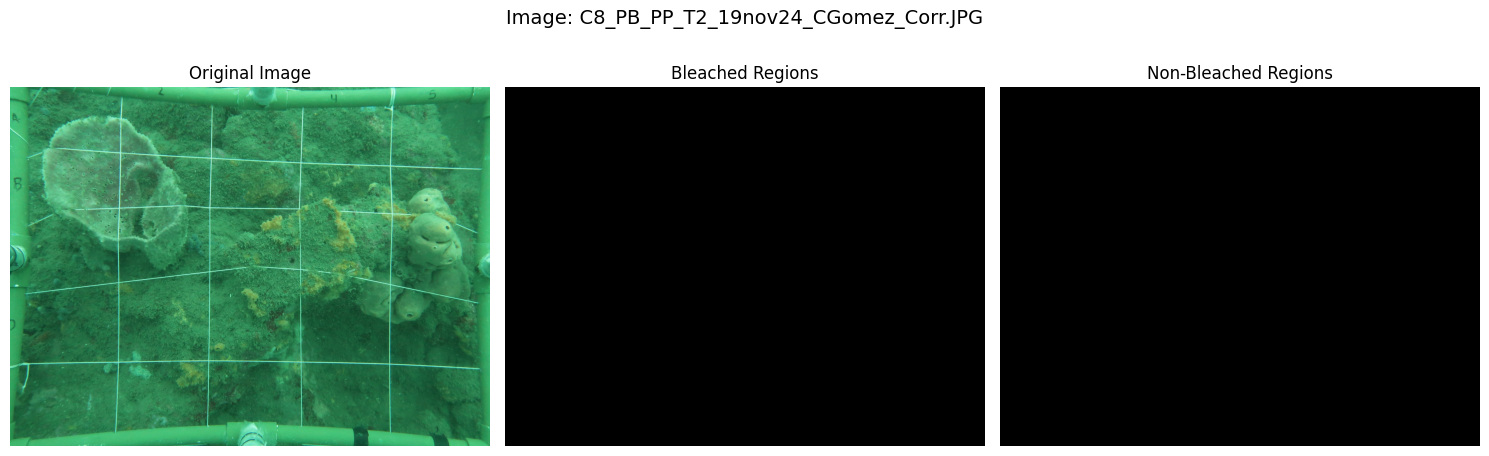


Sample 2:


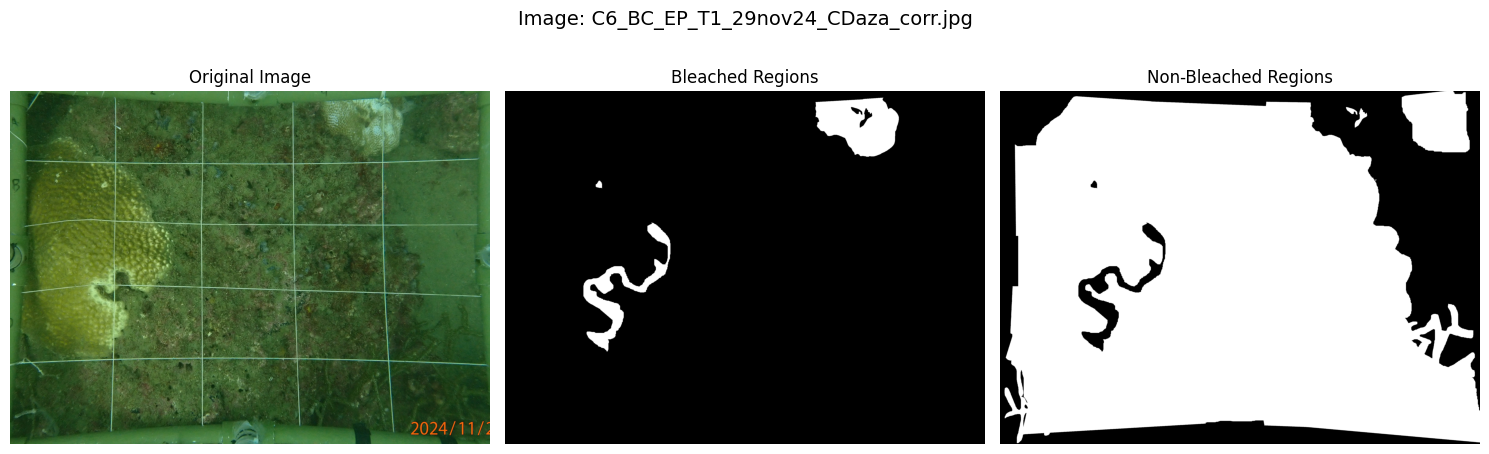


Sample 3:


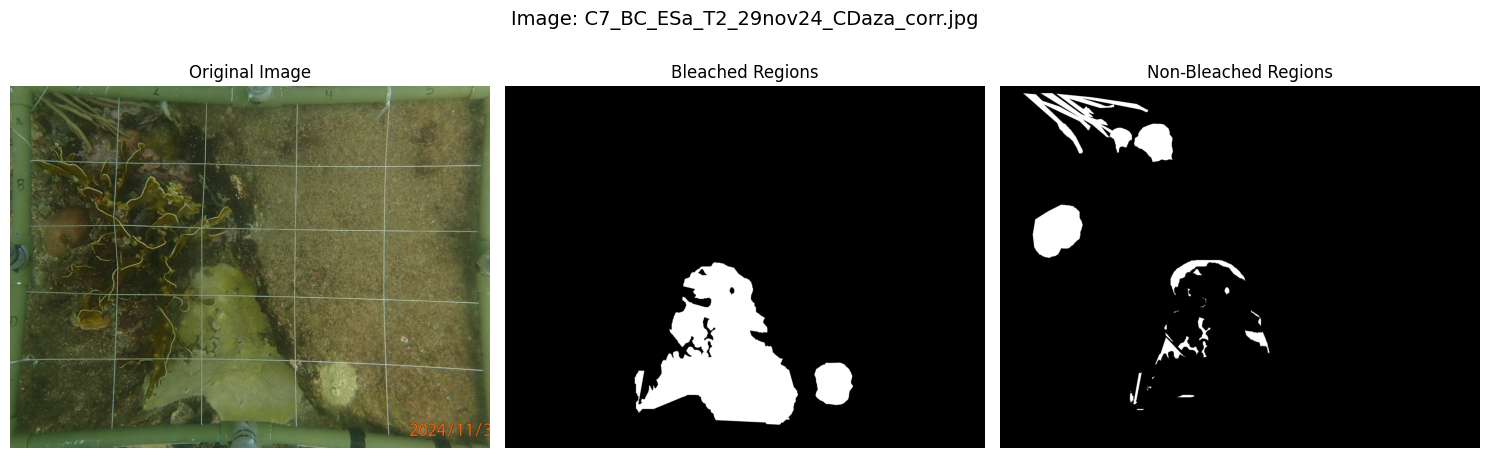


Sample 4:


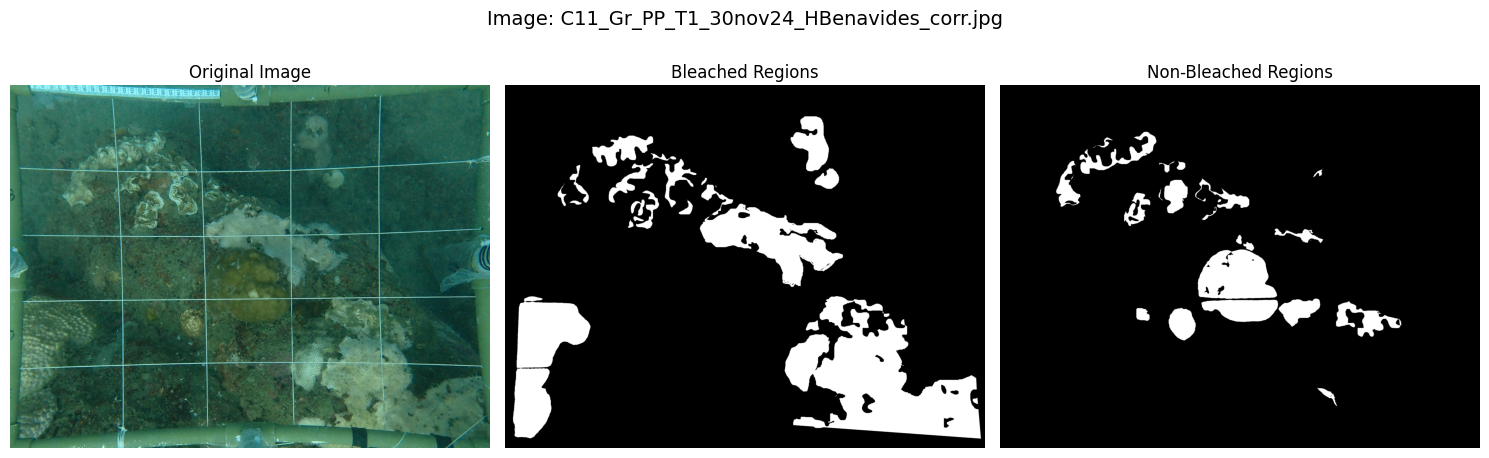


Sample 5:


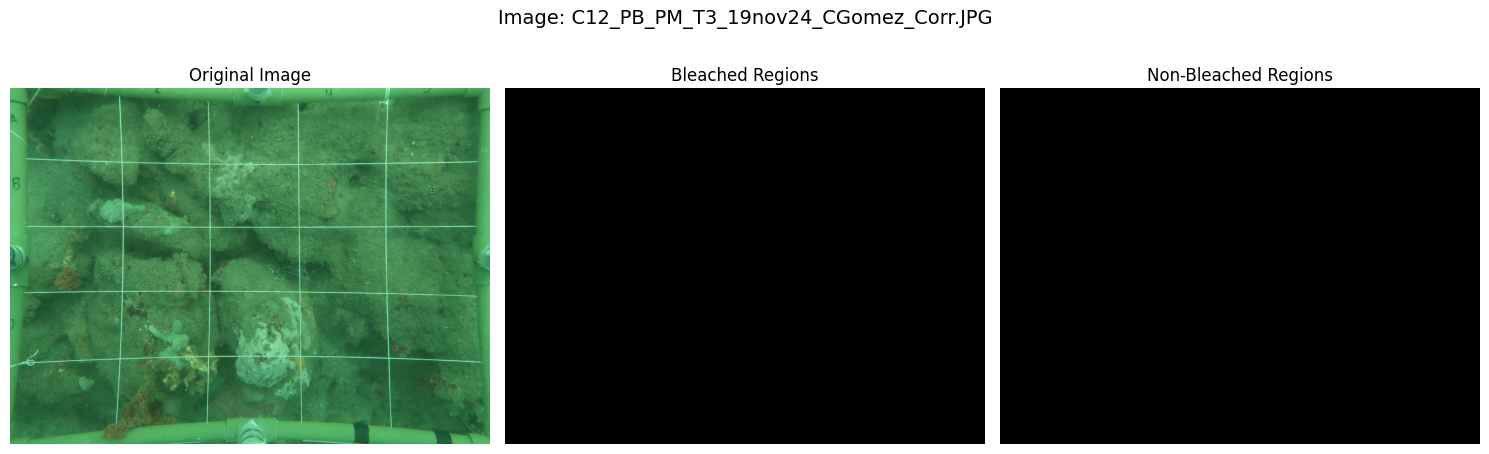

In [7]:
def load_image_triplet(idx):
    """Load original image and its corresponding masks"""
    row = df.iloc[idx]
    
    # Load original image
    img = cv2.imread(str(row['image_path']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load masks
    bleached_mask = cv2.imread(str(row['bleached_mask_path']), cv2.IMREAD_GRAYSCALE) if row['has_bleached_mask'] else None
    non_bleached_mask = cv2.imread(str(row['non_bleached_mask_path']), cv2.IMREAD_GRAYSCALE) if row['has_non_bleached_mask'] else None
    
    return img, bleached_mask, non_bleached_mask, row['image_name']

def plot_image_triplet(idx, figsize=(15, 5)):
    """Plot original image, bleached mask, and non-bleached mask side by side"""
    img, bleached_mask, non_bleached_mask, name = load_image_triplet(idx)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Bleached mask
    if bleached_mask is not None:
        axes[1].imshow(bleached_mask, cmap='gray')
        axes[1].set_title('Bleached Regions')
    else:
        axes[1].text(0.5, 0.5, 'No mask available', ha='center', va='center')
        axes[1].set_title('Bleached Regions (Missing)')
    axes[1].axis('off')
    
    # Non-bleached mask
    if non_bleached_mask is not None:
        axes[2].imshow(non_bleached_mask, cmap='gray')
        axes[2].set_title('Non-Bleached Regions')
    else:
        axes[2].text(0.5, 0.5, 'No mask available', ha='center', va='center')
        axes[2].set_title('Non-Bleached Regions (Missing)')
    axes[2].axis('off')
    
    plt.suptitle(f'Image: {name}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Display several random samples
sample_indices = np.random.choice(len(df), 5, replace=False)
print("Random samples from the dataset:")
for i, idx in enumerate(sample_indices):
    print(f"\nSample {i+1}:")
    plot_image_triplet(idx)

Overlay visualizations:


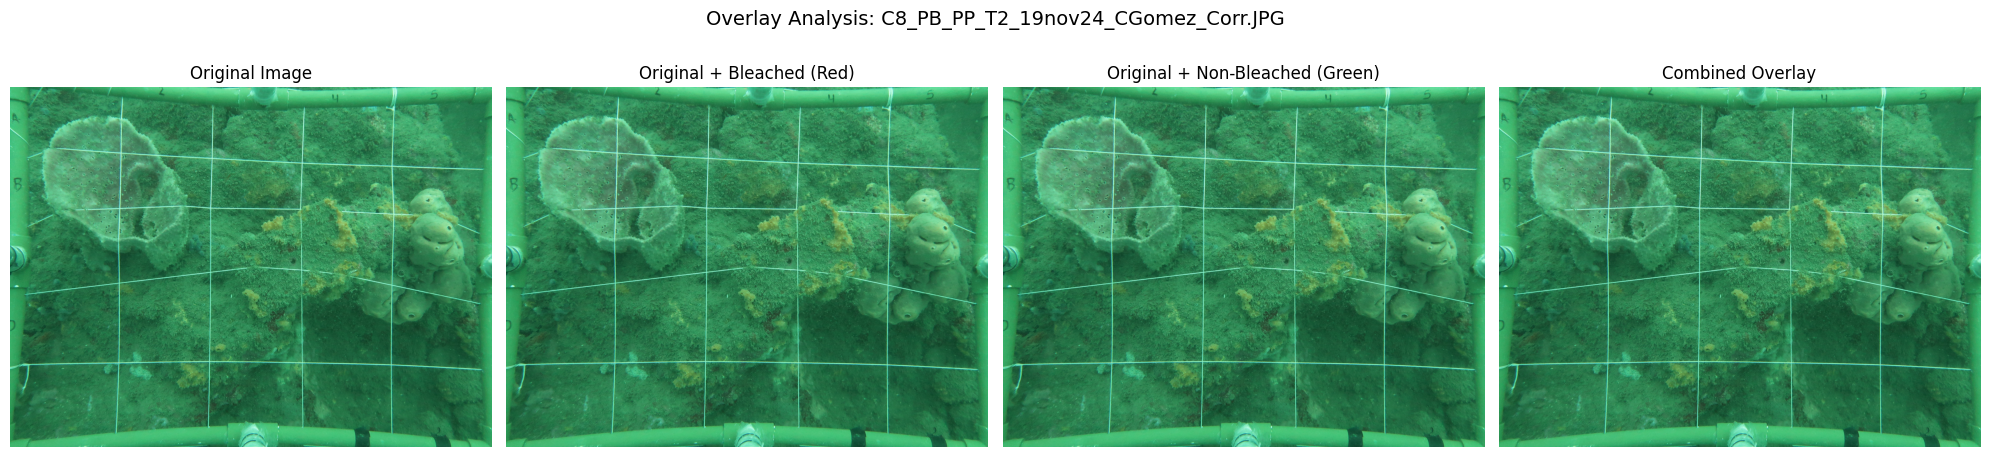

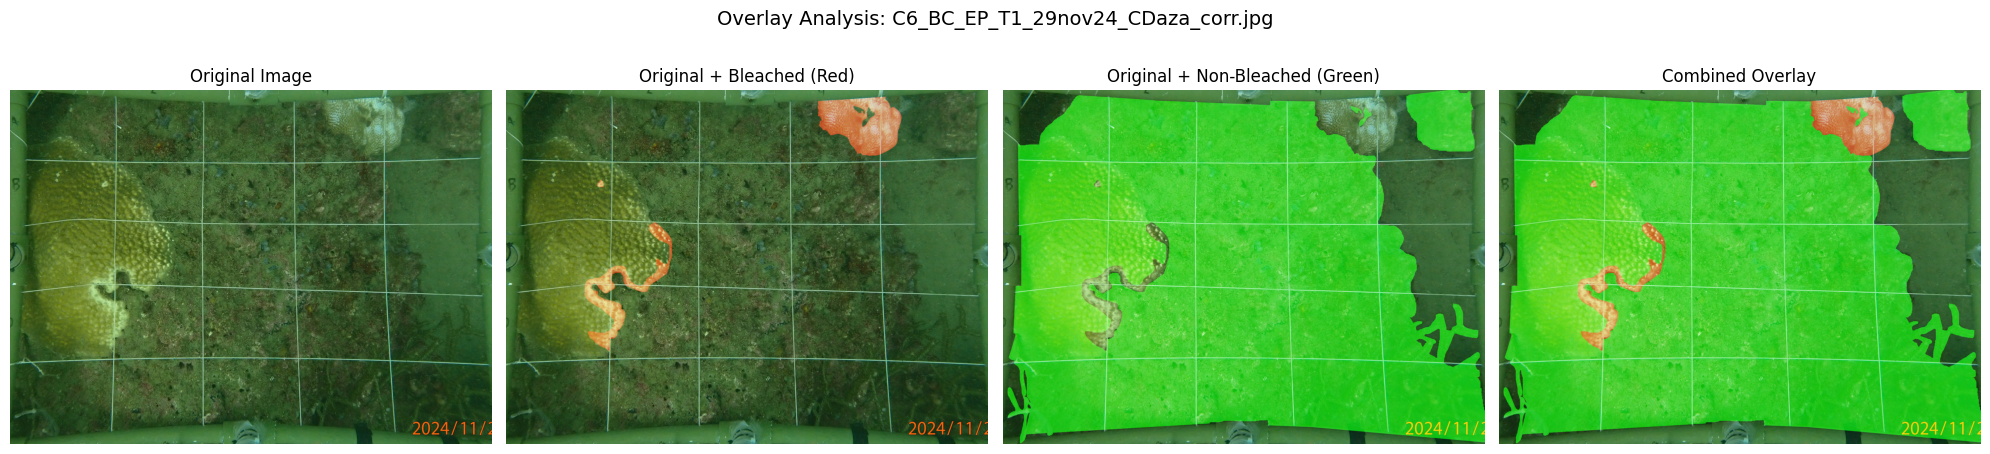

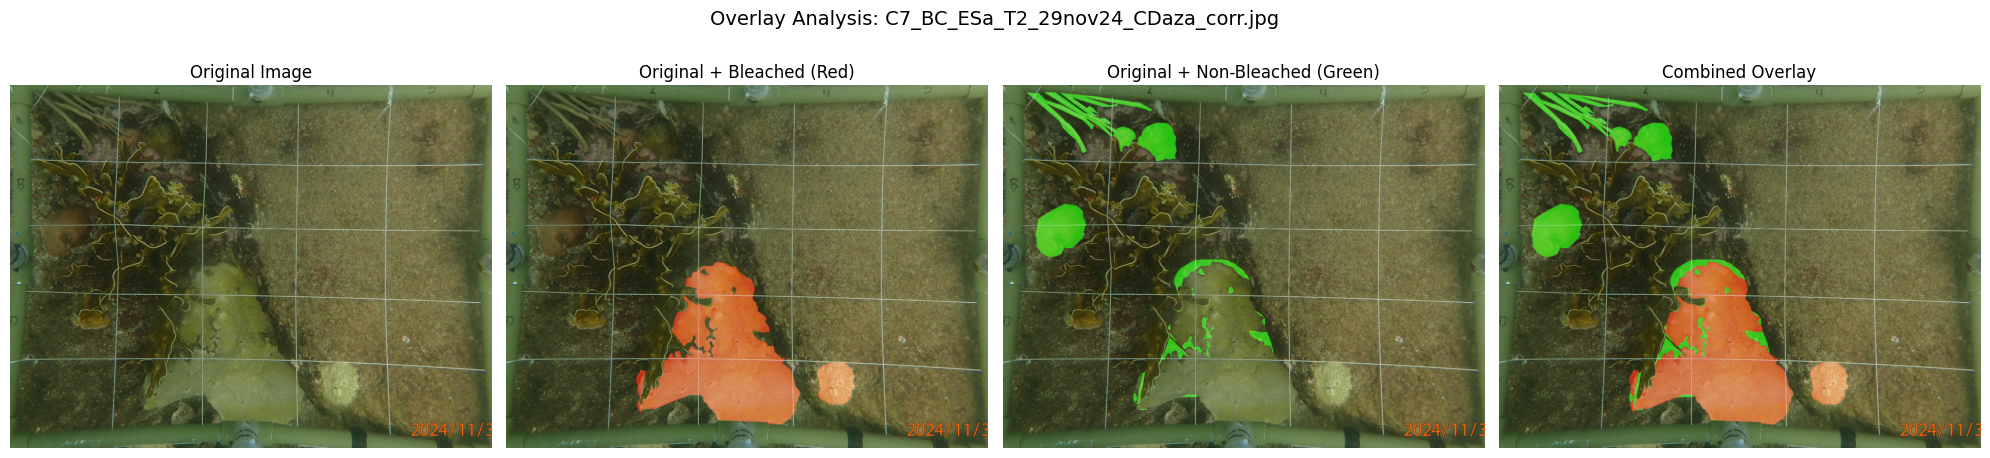

In [8]:
def create_overlay_visualization(idx, alpha=0.7):
    """Create overlay of original image with bleached and non-bleached masks"""
    img, bleached_mask, non_bleached_mask, name = load_image_triplet(idx)
    
    if bleached_mask is None or non_bleached_mask is None:
        print(f"Cannot create overlay for {name} - missing masks")
        return
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Overlay with bleached regions (red)
    overlay1 = img.copy()
    overlay1[:,:,0] = np.where(bleached_mask > 127, 
                              overlay1[:,:,0] * (1-alpha) + 255 * alpha, 
                              overlay1[:,:,0])
    axes[1].imshow(overlay1)
    axes[1].set_title('Original + Bleached (Red)')
    axes[1].axis('off')
    
    # Overlay with non-bleached regions (green)
    overlay2 = img.copy()
    overlay2[:,:,1] = np.where(non_bleached_mask > 127, 
                              overlay2[:,:,1] * (1-alpha) + 255 * alpha, 
                              overlay2[:,:,1])
    axes[2].imshow(overlay2)
    axes[2].set_title('Original + Non-Bleached (Green)')
    axes[2].axis('off')
    
    # Combined overlay (bleached=red, non-bleached=green)
    overlay3 = img.copy().astype(float)
    overlay3[:,:,0] = np.where(bleached_mask > 127, 
                              overlay3[:,:,0] * (1-alpha) + 255 * alpha, 
                              overlay3[:,:,0])
    overlay3[:,:,1] = np.where(non_bleached_mask > 127, 
                              overlay3[:,:,1] * (1-alpha) + 255 * alpha, 
                              overlay3[:,:,1])
    axes[3].imshow(overlay3.astype(np.uint8))
    axes[3].set_title('Combined Overlay')
    axes[3].axis('off')
    
    plt.suptitle(f'Overlay Analysis: {name}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Create overlay visualizations for a few samples
print("Overlay visualizations:")
for i in range(3):
    idx = sample_indices[i]
    create_overlay_visualization(idx)

In [9]:
# Analyze image dimensions and properties
image_properties = []

print("Analyzing image properties...")
for idx in range(len(df)):  # Sample images for efficiency
    img, bleached_mask, non_bleached_mask, name = load_image_triplet(idx)
    
    properties = {
        'image_name': name,
        'height': img.shape[0],
        'width': img.shape[1],
        'channels': img.shape[2],
        'total_pixels': img.shape[0] * img.shape[1]
    }
    
    if bleached_mask is not None:
        properties['bleached_pixels'] = np.sum(bleached_mask > 127)
        properties['bleached_percentage'] = (properties['bleached_pixels'] / properties['total_pixels']) * 100
    else:
        properties['bleached_pixels'] = 0
        properties['bleached_percentage'] = 0
        
    if non_bleached_mask is not None:
        properties['non_bleached_pixels'] = np.sum(non_bleached_mask > 127)
        properties['non_bleached_percentage'] = (properties['non_bleached_pixels'] / properties['total_pixels']) * 100
    else:
        properties['non_bleached_pixels'] = 0
        properties['non_bleached_percentage'] = 0
    
    properties['total_coral_percentage'] = properties['bleached_percentage'] + properties['non_bleached_percentage']
    
    image_properties.append(properties)

props_df = pd.DataFrame(image_properties)
print(f"Analyzed {len(props_df)} images")
print("\nImage Properties Summary:")
print(props_df[['height', 'width', 'total_pixels', 'bleached_percentage', 'non_bleached_percentage', 'total_coral_percentage']].describe())

Analyzing image properties...
Analyzed 658 images

Image Properties Summary:
            height        width  total_pixels  bleached_percentage  \
count   658.000000   658.000000  6.580000e+02           658.000000   
mean   2662.031915  3530.083587  9.502249e+06             9.802737   
std     282.250222   377.064276  2.118126e+06            14.732345   
min    2306.000000  3121.000000  7.303125e+06             0.000000   
25%    2493.000000  3321.000000  8.333069e+06             0.163579   
50%    2550.000000  3385.000000  8.652975e+06             3.325609   
75%    2659.000000  3449.000000  9.076750e+06            13.101977   
max    3273.000000  4304.000000  1.392007e+07            81.466138   

       non_bleached_percentage  total_coral_percentage  
count               658.000000              658.000000  
mean                 24.600306               34.403043  
std                  20.723949               24.498106  
min                   0.000000                0.000000  
25%    

In [10]:
props_df[['height', 'width', 'total_pixels', 'bleached_percentage', 'non_bleached_percentage', 'total_coral_percentage']].describe()

height        width  total_pixels  bleached_percentage  \
count   658.000000   658.000000  6.580000e+02           658.000000   
mean   2662.031915  3530.083587  9.502249e+06             9.802737   
std     282.250222   377.064276  2.118126e+06            14.732345   
min    2306.000000  3121.000000  7.303125e+06             0.000000   
25%    2493.000000  3321.000000  8.333069e+06             0.163579   
50%    2550.000000  3385.000000  8.652975e+06             3.325609   
75%    2659.000000  3449.000000  9.076750e+06            13.101977   
max    3273.000000  4304.000000  1.392007e+07            81.466138   

       non_bleached_percentage  total_coral_percentage  
count               658.000000              658.000000  
mean                 24.600306               34.403043  
std                  20.723949               24.498106  
min                   0.000000                0.000000  
25%                   5.941827               12.783698  
50%                  20.654500               34.525358  
75%                  39.068861               54.165381  
max                  87.722733               88.366145

## 3. Statistical Analysis of Bleaching Patterns

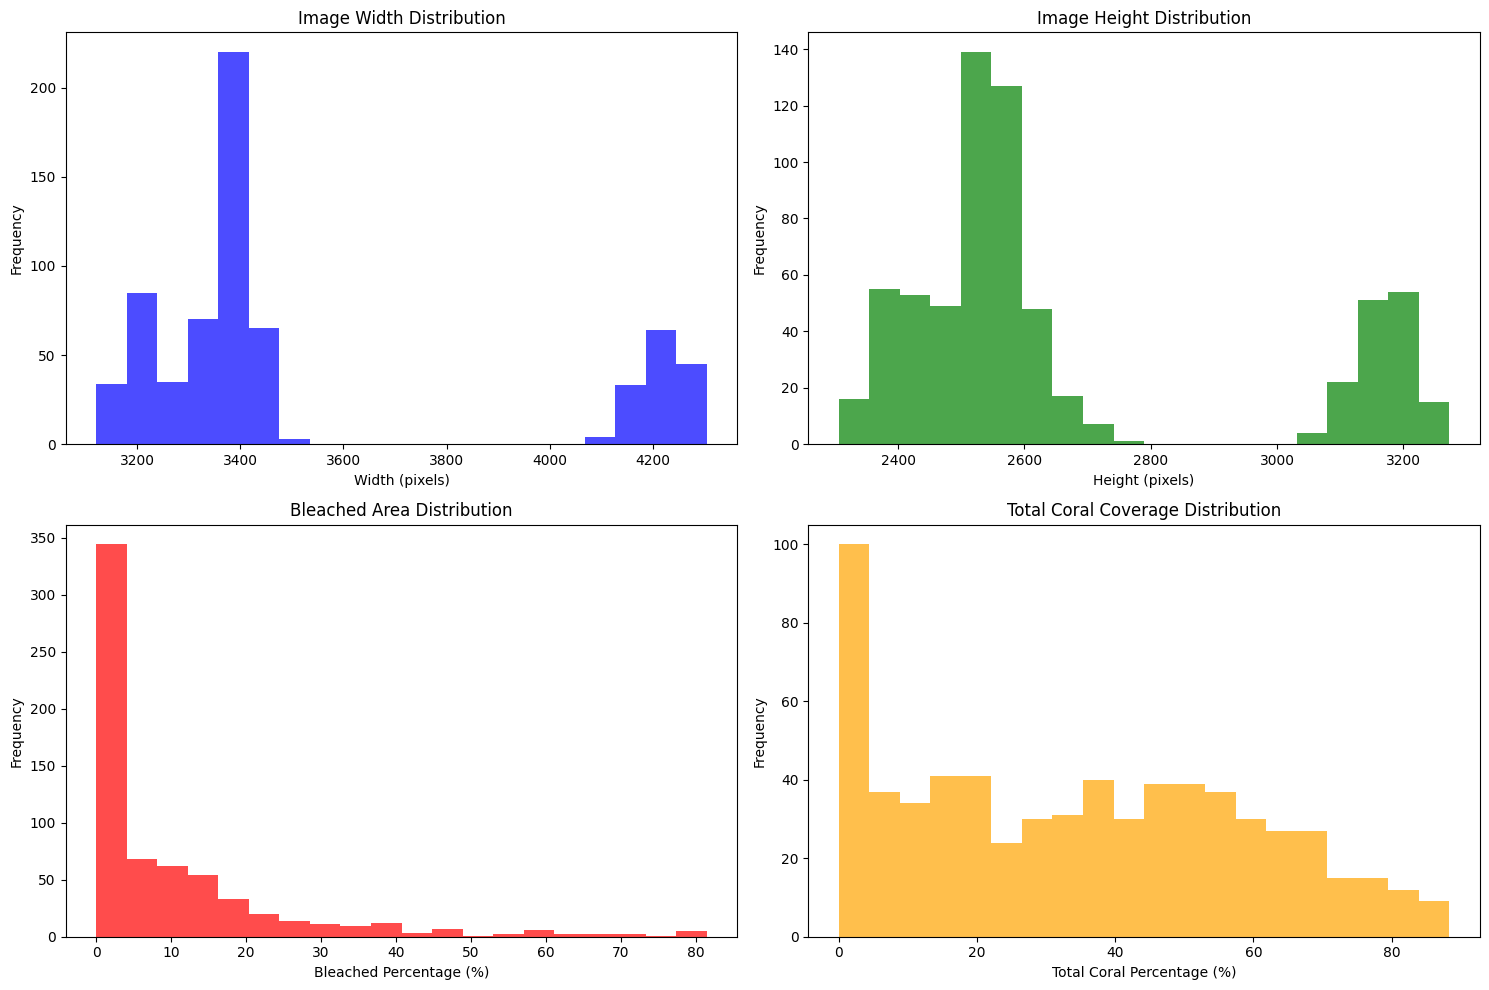

In [12]:
# Distribution of image dimensions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Image dimensions
axes[0,0].hist(props_df['width'], bins=20, alpha=0.7, color='blue')
axes[0,0].set_title('Image Width Distribution')
axes[0,0].set_xlabel('Width (pixels)')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(props_df['height'], bins=20, alpha=0.7, color='green')
axes[0,1].set_title('Image Height Distribution')
axes[0,1].set_xlabel('Height (pixels)')
axes[0,1].set_ylabel('Frequency')

# Bleaching percentages
axes[1,0].hist(props_df['bleached_percentage'], bins=20, alpha=0.7, color='red')
axes[1,0].set_title('Bleached Area Distribution')
axes[1,0].set_xlabel('Bleached Percentage (%)')
axes[1,0].set_ylabel('Frequency')

axes[1,1].hist(props_df['total_coral_percentage'], bins=20, alpha=0.7, color='orange')
axes[1,1].set_title('Total Coral Coverage Distribution')
axes[1,1].set_xlabel('Total Coral Percentage (%)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

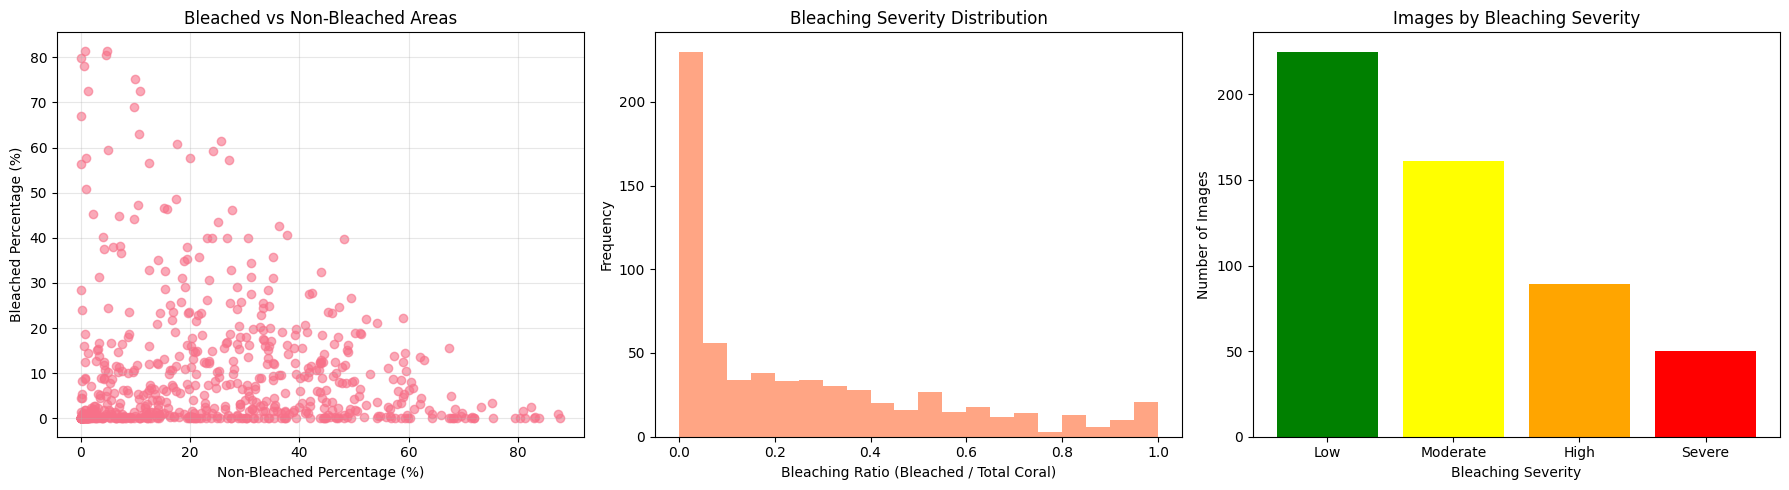


Bleaching Severity Summary:
severity_category
Low         225
Moderate    161
High         89
Severe       50
Name: count, dtype: int64

Average bleaching ratio: 0.260
Median bleaching ratio: 0.169


In [13]:
# Bleaching severity analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot: bleached vs non-bleached percentage
axes[0].scatter(props_df['non_bleached_percentage'], props_df['bleached_percentage'], alpha=0.6)
axes[0].set_xlabel('Non-Bleached Percentage (%)')
axes[0].set_ylabel('Bleached Percentage (%)')
axes[0].set_title('Bleached vs Non-Bleached Areas')
axes[0].grid(True, alpha=0.3)

# Calculate bleaching ratio (bleached / total coral)
props_df['bleaching_ratio'] = props_df['bleached_percentage'] / (props_df['bleached_percentage'] + props_df['non_bleached_percentage'] + 1e-8)

# Bleaching ratio distribution
axes[1].hist(props_df['bleaching_ratio'], bins=20, alpha=0.7, color='coral')
axes[1].set_xlabel('Bleaching Ratio (Bleached / Total Coral)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Bleaching Severity Distribution')

# Box plot of bleaching severity categories
props_df['severity_category'] = pd.cut(props_df['bleaching_ratio'], 
                                     bins=[0, 0.2, 0.5, 0.8, 1.0], 
                                     labels=['Low', 'Moderate', 'High', 'Severe'])

severity_counts = props_df['severity_category'].value_counts()
axes[2].bar(severity_counts.index, severity_counts.values, color=['green', 'yellow', 'orange', 'red'])
axes[2].set_xlabel('Bleaching Severity')
axes[2].set_ylabel('Number of Images')
axes[2].set_title('Images by Bleaching Severity')

plt.tight_layout()
plt.show()

print("\nBleaching Severity Summary:")
print(severity_counts)
print(f"\nAverage bleaching ratio: {props_df['bleaching_ratio'].mean():.3f}")
print(f"Median bleaching ratio: {props_df['bleaching_ratio'].median():.3f}")

## 4. Advanced Visualizations & Color Analysis

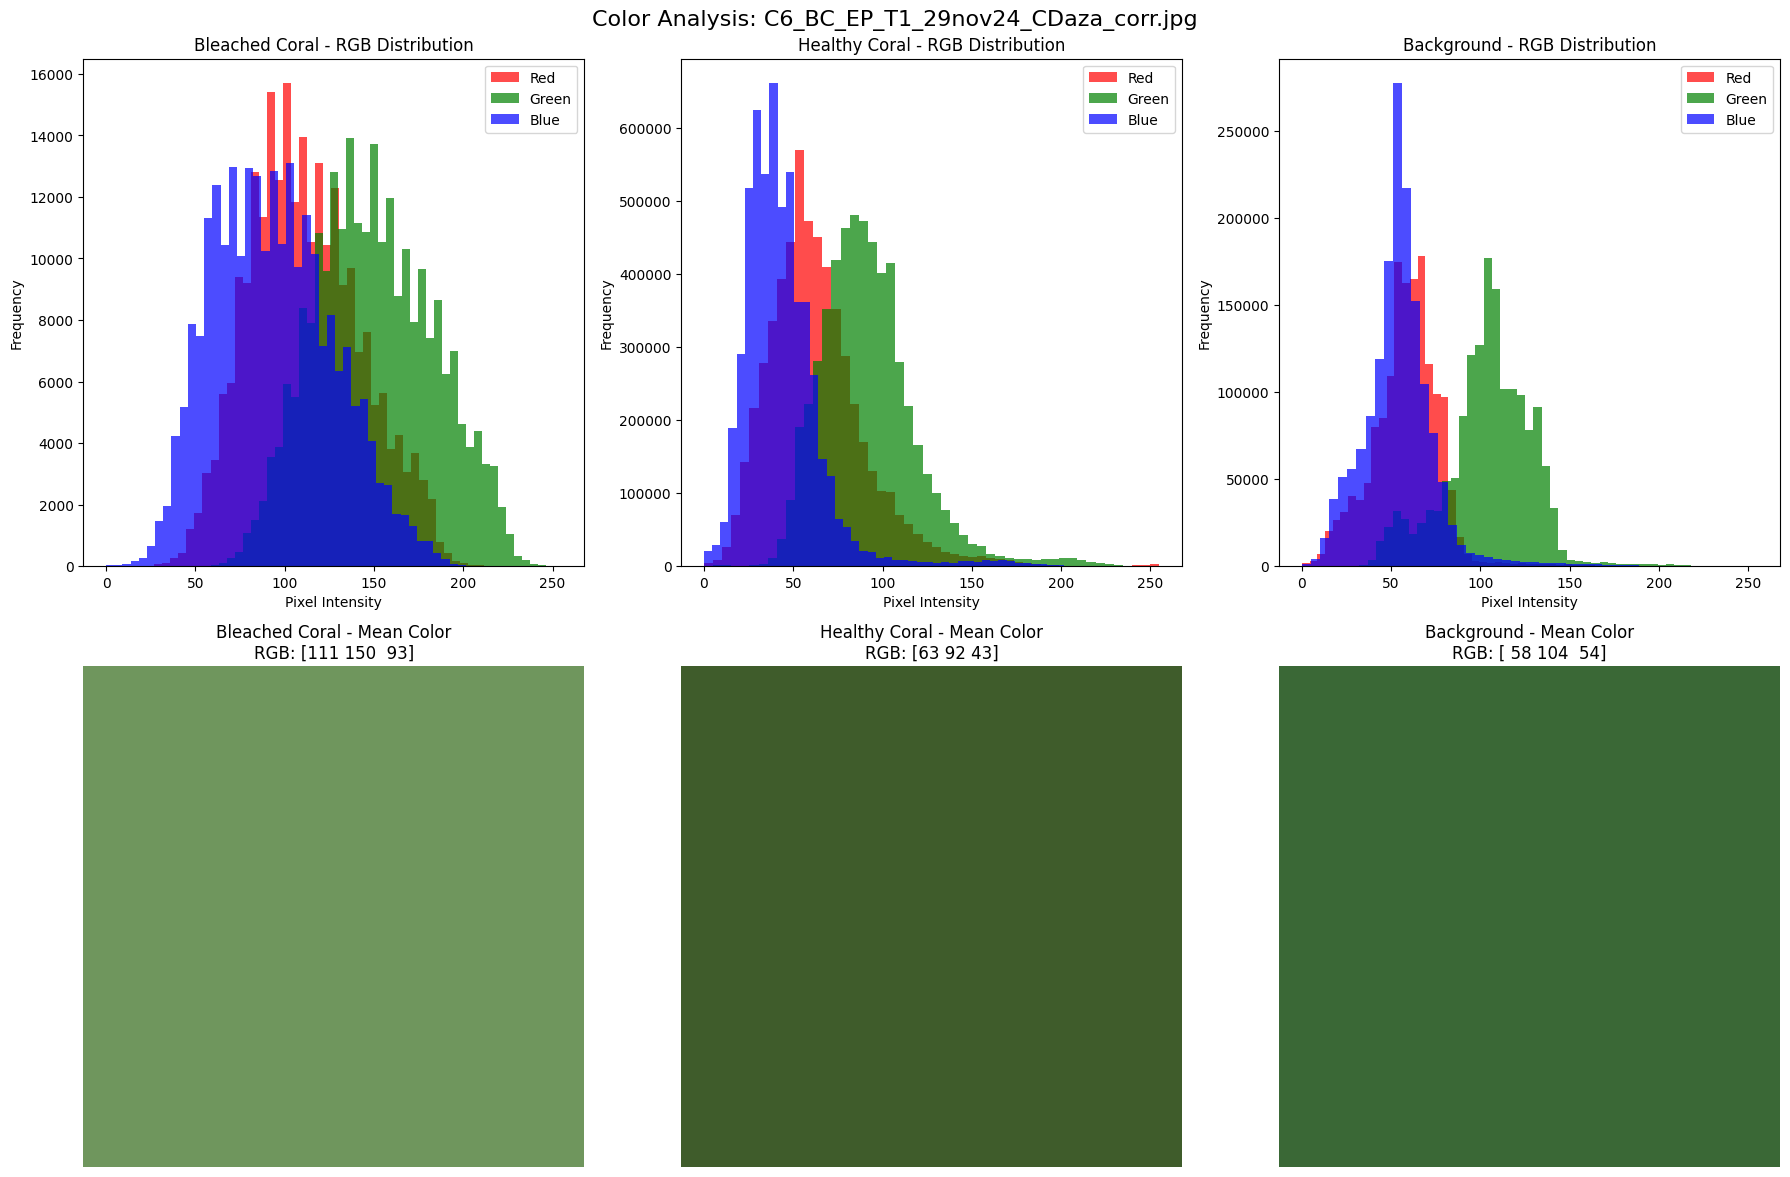

In [17]:
def analyze_color_distribution(idx):
    """Analyze color distribution in different regions of the image"""
    img, bleached_mask, non_bleached_mask, name = load_image_triplet(idx)
    
    if bleached_mask is None or non_bleached_mask is None:
        return None
    
    # Extract pixels from different regions
    bleached_pixels = img[bleached_mask > 127]
    non_bleached_pixels = img[non_bleached_mask > 127]
    background_mask = (bleached_mask <= 127) & (non_bleached_mask <= 127)
    background_pixels = img[background_mask]
    
    return {
        'bleached': bleached_pixels,
        'non_bleached': non_bleached_pixels,
        'background': background_pixels,
        'name': name
    }

# Analyze color distribution for a sample image
sample_idx = sample_indices[1]
color_analysis = analyze_color_distribution(sample_idx)

if color_analysis:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    regions = ['bleached', 'non_bleached', 'background']
    colors = ['red', 'green', 'blue']
    titles = ['Bleached Coral', 'Healthy Coral', 'Background']
    
    for i, (region, color, title) in enumerate(zip(regions, colors, titles)):
        if len(color_analysis[region]) > 0:
            # RGB histograms
            for channel, channel_name in enumerate(['Red', 'Green', 'Blue']):
                axes[0, i].hist(color_analysis[region][:, channel], bins=50, alpha=0.7, 
                              color=channel_name.lower(), label=channel_name)
            axes[0, i].set_title(f'{title} - RGB Distribution')
            axes[0, i].set_xlabel('Pixel Intensity')
            axes[0, i].set_ylabel('Frequency')
            axes[0, i].legend()
            
            # Mean color visualization
            mean_color = np.mean(color_analysis[region], axis=0).astype(int)
            color_patch = np.ones((100, 100, 3), dtype=np.uint8) * mean_color
            axes[1, i].imshow(color_patch)
            axes[1, i].set_title(f'{title} - Mean Color\nRGB: {mean_color}')
            axes[1, i].axis('off')
        else:
            axes[0, i].text(0.5, 0.5, 'No pixels', ha='center', va='center')
            axes[1, i].text(0.5, 0.5, 'No pixels', ha='center', va='center')
    
    plt.suptitle(f'Color Analysis: {color_analysis["name"]}', fontsize=16)
    plt.tight_layout()
    plt.show()

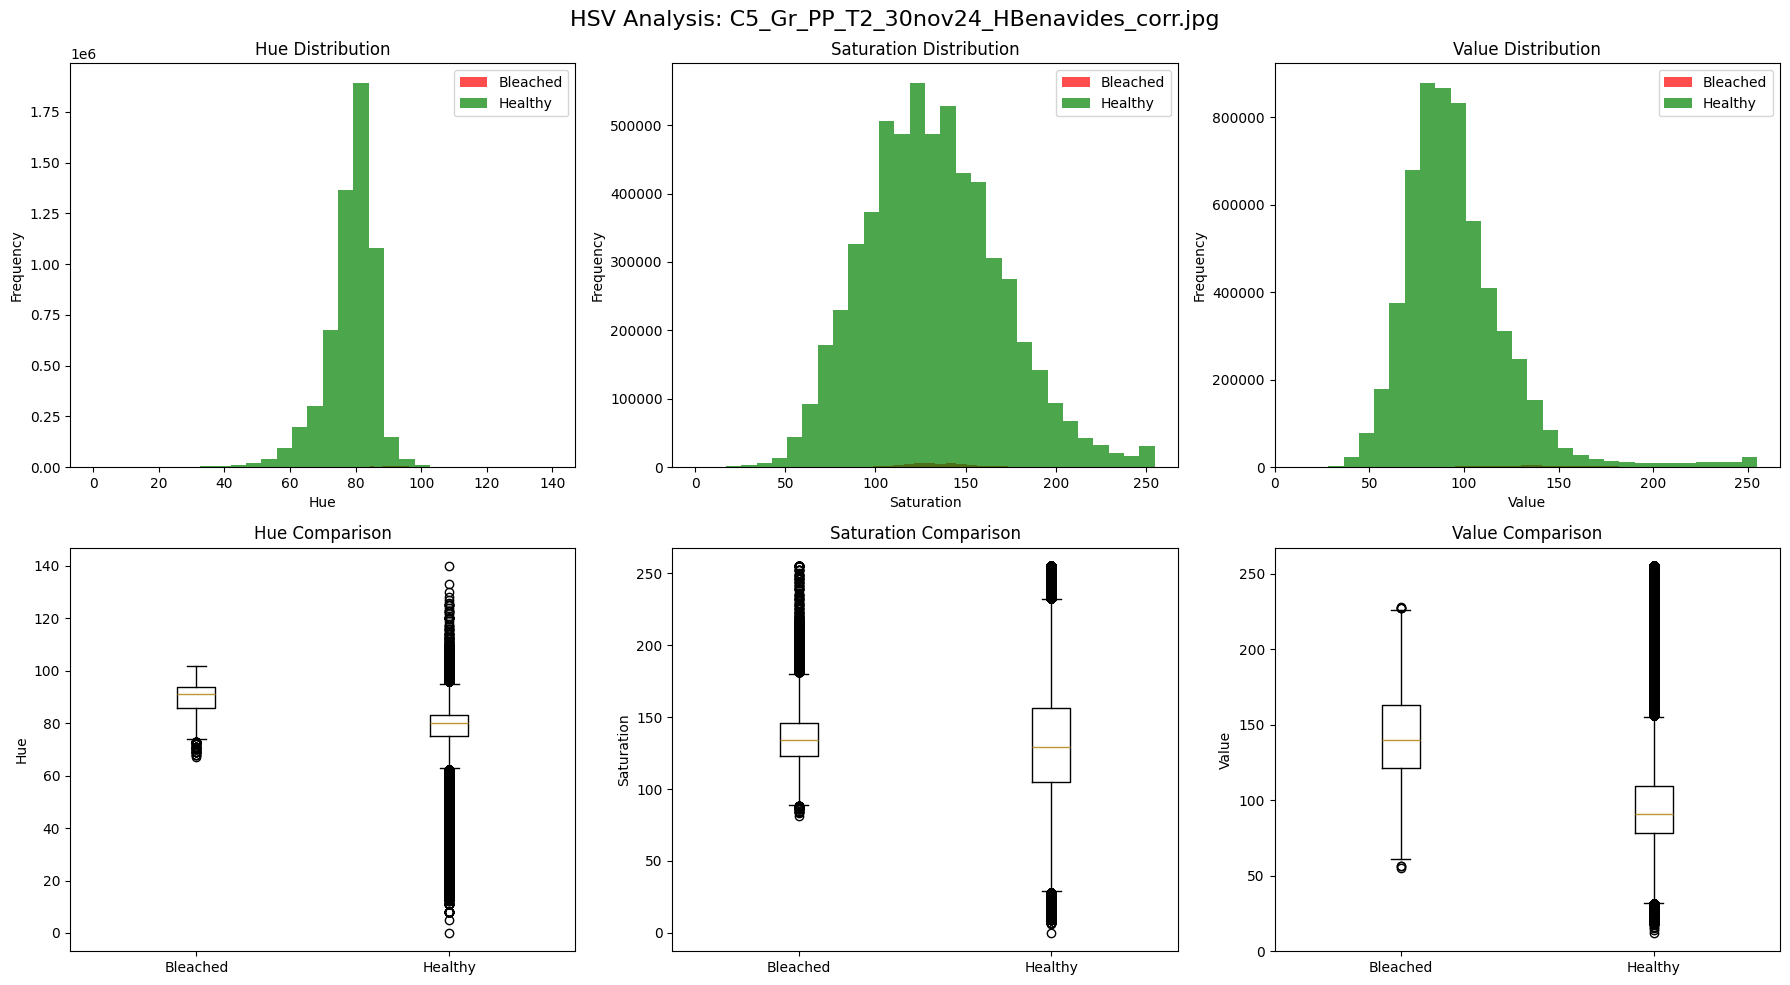


HSV Statistics Comparison:
Hue: Bleached=89.79, Healthy=78.39, Diff=-11.40
Saturation: Bleached=135.41, Healthy=131.72, Diff=-3.69
Value: Bleached=142.56, Healthy=96.04, Diff=-46.53


In [21]:
# HSV color space analysis
def rgb_to_hsv_analysis(idx):
    """Analyze HSV color space characteristics"""
    img, bleached_mask, non_bleached_mask, name = load_image_triplet(idx)
    
    if bleached_mask is None or non_bleached_mask is None:
        return None
    
    # Convert to HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Extract HSV values for different regions
    bleached_hsv = hsv_img[bleached_mask > 127]
    non_bleached_hsv = hsv_img[non_bleached_mask > 127]
    
    return {
        'bleached_hsv': bleached_hsv,
        'non_bleached_hsv': non_bleached_hsv,
        'name': name
    }

hsv_analysis = rgb_to_hsv_analysis(sample_idx)

if hsv_analysis and len(hsv_analysis['bleached_hsv']) > 0 and len(hsv_analysis['non_bleached_hsv']) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    hsv_channels = ['Hue', 'Saturation', 'Value']
    
    for i, channel_name in enumerate(hsv_channels):
        # Bleached coral HSV
        axes[0, i].hist(hsv_analysis['bleached_hsv'][:, i], bins=30, alpha=0.7, 
                       color='red', label='Bleached')
        axes[0, i].hist(hsv_analysis['non_bleached_hsv'][:, i], bins=30, alpha=0.7, 
                       color='green', label='Healthy')
        axes[0, i].set_title(f'{channel_name} Distribution')
        axes[0, i].set_xlabel(channel_name)
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].legend()
        
        # Box plots for comparison
        data_to_plot = [hsv_analysis['bleached_hsv'][:, i], hsv_analysis['non_bleached_hsv'][:, i]]
        axes[1, i].boxplot(data_to_plot, labels=['Bleached', 'Healthy'])
        axes[1, i].set_title(f'{channel_name} Comparison')
        axes[1, i].set_ylabel(channel_name)
    
    plt.suptitle(f'HSV Analysis: {hsv_analysis["name"]}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison
    print("\nHSV Statistics Comparison:")
    for i, channel in enumerate(['Hue', 'Saturation', 'Value']):
        bleached_mean = np.mean(hsv_analysis['bleached_hsv'][:, i])
        healthy_mean = np.mean(hsv_analysis['non_bleached_hsv'][:, i])
        print(f"{channel}: Bleached={bleached_mean:.2f}, Healthy={healthy_mean:.2f}, Diff={healthy_mean-bleached_mean:.2f}")

## 5. Mask Quality Assessment

Mask Quality Assessment:
Images with overlapping masks: 0/5
Average overlap percentage: 0.000%
Average coral coverage: 32.47%
All mask shapes match: True


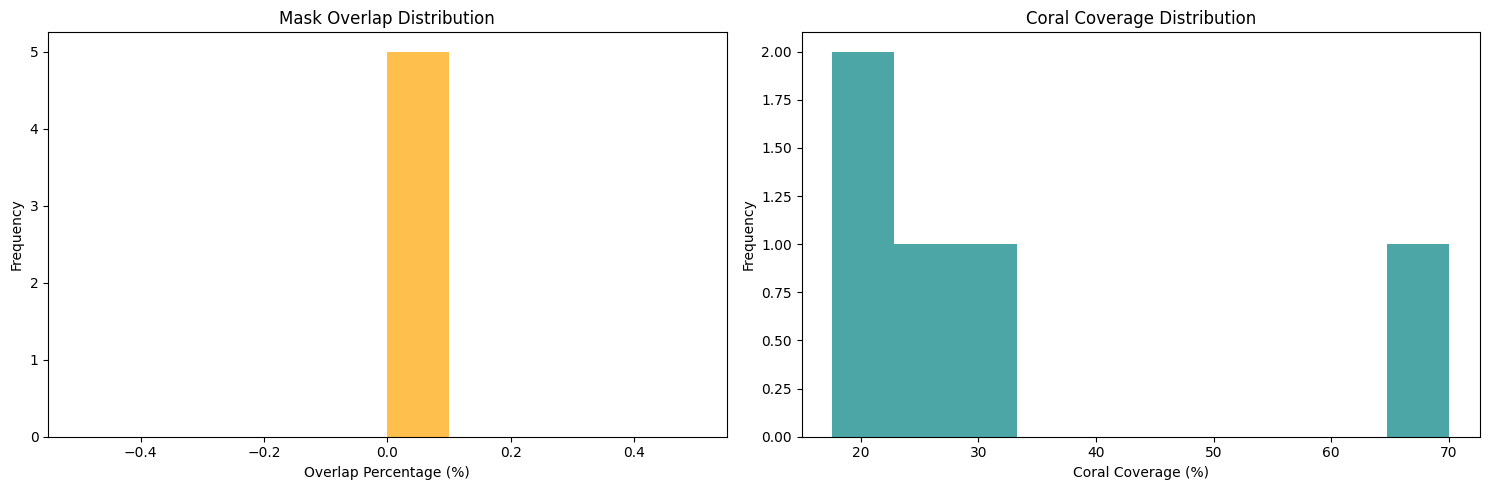

In [22]:
def assess_mask_quality(idx):
    """Assess the quality and consistency of masks"""
    img, bleached_mask, non_bleached_mask, name = load_image_triplet(idx)
    
    if bleached_mask is None or non_bleached_mask is None:
        return None
    
    # Check for overlaps
    overlap = (bleached_mask > 127) & (non_bleached_mask > 127)
    overlap_pixels = np.sum(overlap)
    
    # Check for gaps (areas that should be coral but aren't marked)
    total_coral_mask = (bleached_mask > 127) | (non_bleached_mask > 127)
    
    # Calculate coverage statistics
    total_pixels = img.shape[0] * img.shape[1]
    bleached_pixels = np.sum(bleached_mask > 127)
    non_bleached_pixels = np.sum(non_bleached_mask > 127)
    total_coral_pixels = np.sum(total_coral_mask)
    
    return {
        'name': name,
        'overlap_pixels': overlap_pixels,
        'overlap_percentage': (overlap_pixels / total_pixels) * 100,
        'bleached_pixels': bleached_pixels,
        'non_bleached_pixels': non_bleached_pixels,
        'total_coral_pixels': total_coral_pixels,
        'coral_coverage': (total_coral_pixels / total_pixels) * 100,
        'mask_shapes_match': bleached_mask.shape == non_bleached_mask.shape == img.shape[:2]
    }

# Assess mask quality for sample images
mask_quality_results = []
for idx in sample_indices:
    result = assess_mask_quality(idx)
    if result:
        mask_quality_results.append(result)

if mask_quality_results:
    quality_df = pd.DataFrame(mask_quality_results)
    
    print("Mask Quality Assessment:")
    print(f"Images with overlapping masks: {(quality_df['overlap_pixels'] > 0).sum()}/{len(quality_df)}")
    print(f"Average overlap percentage: {quality_df['overlap_percentage'].mean():.3f}%")
    print(f"Average coral coverage: {quality_df['coral_coverage'].mean():.2f}%")
    print(f"All mask shapes match: {quality_df['mask_shapes_match'].all()}")
    
    # Visualize mask quality issues
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].hist(quality_df['overlap_percentage'], bins=10, alpha=0.7, color='orange')
    axes[0].set_title('Mask Overlap Distribution')
    axes[0].set_xlabel('Overlap Percentage (%)')
    axes[0].set_ylabel('Frequency')
    
    axes[1].hist(quality_df['coral_coverage'], bins=10, alpha=0.7, color='teal')
    axes[1].set_title('Coral Coverage Distribution')
    axes[1].set_xlabel('Coral Coverage (%)')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


Image with highest overlap: C5_Gr_PP_T2_30nov24_HBenavides_corr.jpg
Overlap percentage: 0.000%


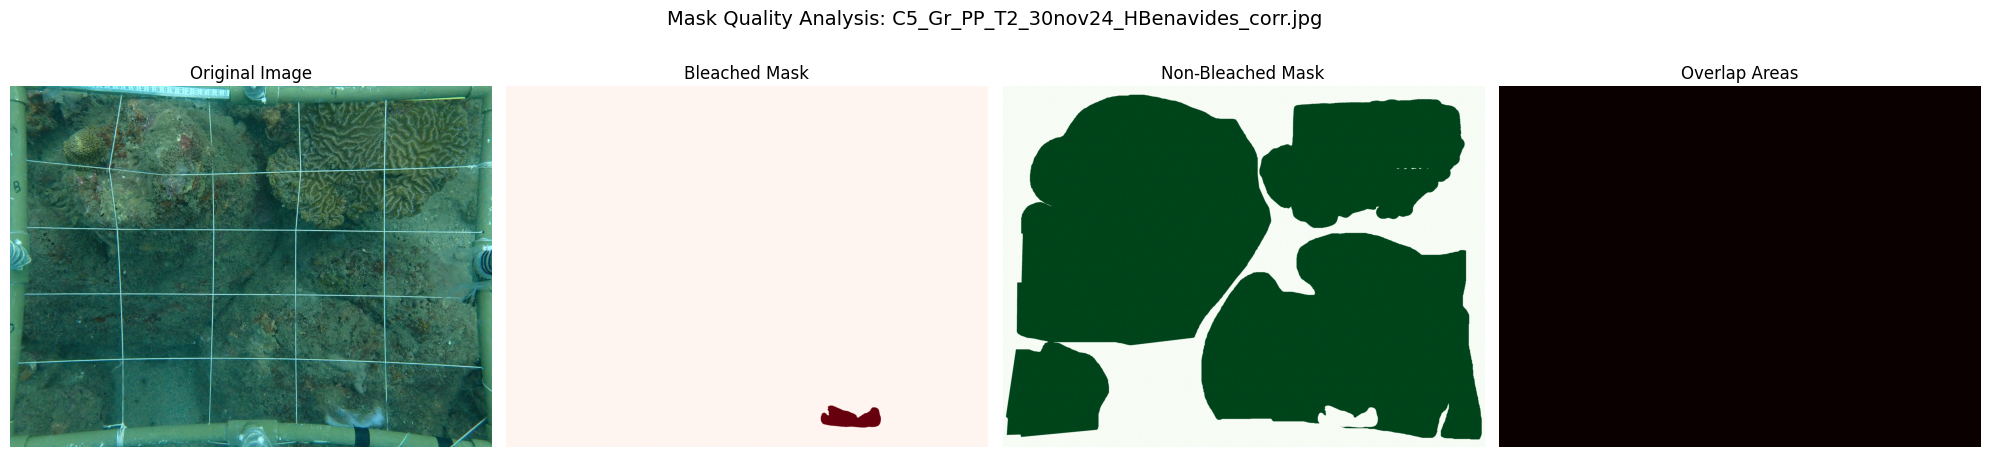

In [24]:
# Visualize problematic cases (if any)
if mask_quality_results:
    # Find images with highest overlap
    high_overlap_idx = quality_df['overlap_percentage'].idxmax()
    high_overlap_sample = sample_indices[high_overlap_idx]
    
    print(f"\nImage with highest overlap: {quality_df.iloc[high_overlap_idx]['name']}")
    print(f"Overlap percentage: {quality_df.iloc[high_overlap_idx]['overlap_percentage']:.3f}%")
    
    # Visualize the overlap
    img, bleached_mask, non_bleached_mask, name = load_image_triplet(high_overlap_sample)
    
    if bleached_mask is not None and non_bleached_mask is not None:
        overlap = (bleached_mask > 127) & (non_bleached_mask > 127)
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(bleached_mask, cmap='Reds')
        axes[1].set_title('Bleached Mask')
        axes[1].axis('off')
        
        axes[2].imshow(non_bleached_mask, cmap='Greens')
        axes[2].set_title('Non-Bleached Mask')
        axes[2].axis('off')
        
        axes[3].imshow(overlap, cmap='hot')
        axes[3].set_title('Overlap Areas')
        axes[3].axis('off')
        
        plt.suptitle(f'Mask Quality Analysis: {name}', fontsize=14)
        plt.tight_layout()
        plt.show()

## 6. Feature Engineering Ideas & Insights

Texture Analysis Results:
Average texture contrast (healthy - bleached): 6.683
Bleached coral texture mean: 37.944
Healthy coral texture mean: 44.628


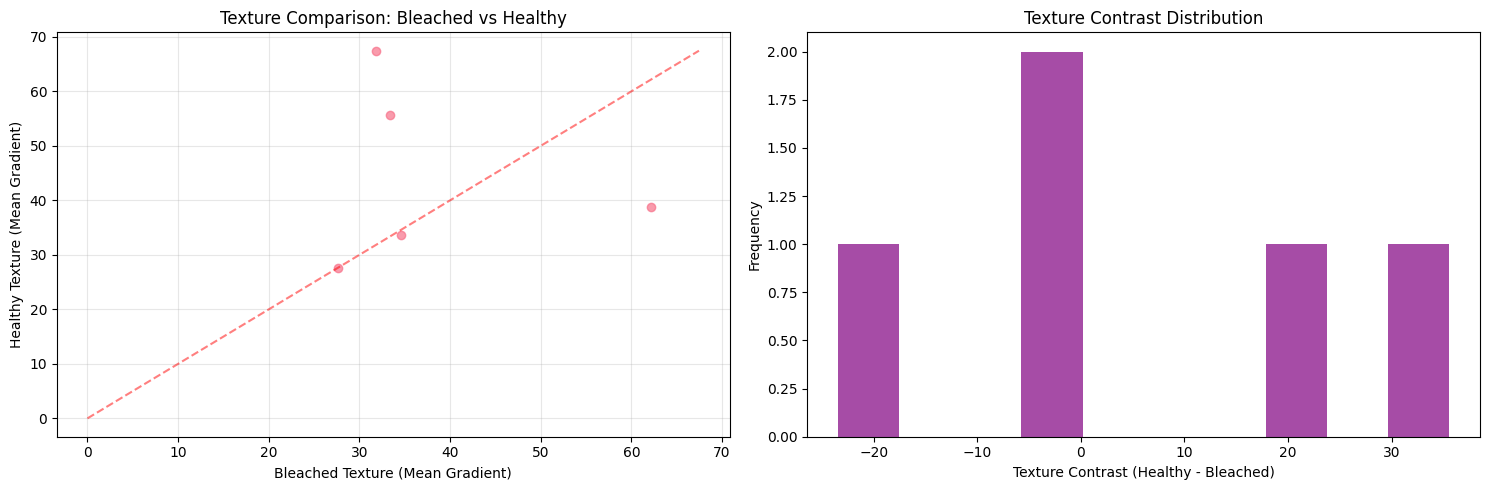

In [25]:
def extract_texture_features(idx):
    """Extract texture features from different regions"""
    img, bleached_mask, non_bleached_mask, name = load_image_triplet(idx)
    
    if bleached_mask is None or non_bleached_mask is None:
        return None
    
    # Convert to grayscale for texture analysis
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate gradients (edge information)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Extract texture statistics for different regions
    bleached_texture = gradient_magnitude[bleached_mask > 127]
    non_bleached_texture = gradient_magnitude[non_bleached_mask > 127]
    
    if len(bleached_texture) == 0 or len(non_bleached_texture) == 0:
        return None
    
    return {
        'name': name,
        'bleached_texture_mean': np.mean(bleached_texture),
        'bleached_texture_std': np.std(bleached_texture),
        'non_bleached_texture_mean': np.mean(non_bleached_texture),
        'non_bleached_texture_std': np.std(non_bleached_texture),
        'texture_contrast': np.mean(non_bleached_texture) - np.mean(bleached_texture)
    }

# Extract texture features for sample images
texture_results = []
for idx in sample_indices:
    result = extract_texture_features(idx)
    if result:
        texture_results.append(result)

if texture_results:
    texture_df = pd.DataFrame(texture_results)
    
    print("Texture Analysis Results:")
    print(f"Average texture contrast (healthy - bleached): {texture_df['texture_contrast'].mean():.3f}")
    print(f"Bleached coral texture mean: {texture_df['bleached_texture_mean'].mean():.3f}")
    print(f"Healthy coral texture mean: {texture_df['non_bleached_texture_mean'].mean():.3f}")
    
    # Visualize texture differences
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].scatter(texture_df['bleached_texture_mean'], texture_df['non_bleached_texture_mean'], alpha=0.7)
    axes[0].plot([0, max(texture_df['bleached_texture_mean'].max(), texture_df['non_bleached_texture_mean'].max())], 
                [0, max(texture_df['bleached_texture_mean'].max(), texture_df['non_bleached_texture_mean'].max())], 
                'r--', alpha=0.5)
    axes[0].set_xlabel('Bleached Texture (Mean Gradient)')
    axes[0].set_ylabel('Healthy Texture (Mean Gradient)')
    axes[0].set_title('Texture Comparison: Bleached vs Healthy')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(texture_df['texture_contrast'], bins=10, alpha=0.7, color='purple')
    axes[1].set_xlabel('Texture Contrast (Healthy - Bleached)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Texture Contrast Distribution')
    
    plt.tight_layout()
    plt.show()

In [26]:
# Summary of findings and feature engineering recommendations
print("\n" + "="*80)
print("CORAL BLEACH DETECTION EDA - KEY FINDINGS & RECOMMENDATIONS")
print("="*80)

print("\n1. DATASET OVERVIEW:")
print(f"   • Total images: {len(df)}")
print(f"   • Complete triplets available: {(df['has_bleached_mask'] & df['has_non_bleached_mask']).sum()}")
print(f"   • Data quality: {'Good' if (df['has_bleached_mask'] & df['has_non_bleached_mask']).sum() > len(df)*0.9 else 'Needs attention'}")

if len(props_df) > 0:
    print("\n2. BLEACHING PATTERNS:")
    print(f"   • Average bleaching ratio: {props_df['bleaching_ratio'].mean():.3f}")
    print(f"   • Images with high bleaching (>50%): {(props_df['bleaching_ratio'] > 0.5).sum()}/{len(props_df)}")
    print(f"   • Total coral coverage: {props_df['total_coral_percentage'].mean():.1f}% ± {props_df['total_coral_percentage'].std():.1f}%")

if mask_quality_results:
    print("\n3. MASK QUALITY:")
    print(f"   • Average mask overlap: {quality_df['overlap_percentage'].mean():.3f}%")
    print(f"   • Mask consistency: {'Good' if quality_df['mask_shapes_match'].all() else 'Issues detected'}")

print("\n4. RECOMMENDED FEATURES FOR MODEL TRAINING:")
print("   COLOR FEATURES:")
print("   • RGB intensity means and standard deviations")
print("   • HSV color space features (especially Saturation and Value)")
print("   • Color ratios (R/G, G/B, etc.)")
print("   • Color histogram features")

print("\n   TEXTURE FEATURES:")
print("   • Gradient magnitude statistics")
print("   • Local Binary Patterns (LBP)")
print("   • Gabor filter responses")
print("   • Edge density measures")

print("\n   SPATIAL FEATURES:")
print("   • Bleaching cluster sizes and shapes")
print("   • Spatial distribution patterns")
print("   • Border characteristics between bleached/healthy regions")

print("\n   MORPHOLOGICAL FEATURES:")
print("   • Region connectivity and compactness")
print("   • Aspect ratios of bleached regions")
print("   • Perimeter-to-area ratios")

print("\n5. MODEL DEVELOPMENT STRATEGIES:")
print("   • Semantic segmentation (U-Net, DeepLab) for pixel-level classification")
print("   • Multi-scale analysis for different bleaching pattern sizes")
print("   • Data augmentation (rotation, flipping, color jittering)")
print("   • Transfer learning from pre-trained models")
print("   • Ensemble methods combining multiple feature types")

print("\n6. PREPROCESSING RECOMMENDATIONS:")
print("   • Normalize image intensities")
print("   • Consider histogram equalization for contrast enhancement")
print("   • Handle class imbalance between bleached/healthy pixels")
print("   • Validate mask quality and fix overlaps if necessary")

print("\n" + "="*80)


CORAL BLEACH DETECTION EDA - KEY FINDINGS & RECOMMENDATIONS

1. DATASET OVERVIEW:
   • Total images: 658
   • Complete triplets available: 658
   • Data quality: Good

2. BLEACHING PATTERNS:
   • Average bleaching ratio: 0.260
   • Images with high bleaching (>50%): 139/658
   • Total coral coverage: 34.4% ± 24.5%

3. MASK QUALITY:
   • Average mask overlap: 0.000%
   • Mask consistency: Good

4. RECOMMENDED FEATURES FOR MODEL TRAINING:
   COLOR FEATURES:
   • RGB intensity means and standard deviations
   • HSV color space features (especially Saturation and Value)
   • Color ratios (R/G, G/B, etc.)
   • Color histogram features

   TEXTURE FEATURES:
   • Gradient magnitude statistics
   • Local Binary Patterns (LBP)
   • Gabor filter responses
   • Edge density measures

   SPATIAL FEATURES:
   • Bleaching cluster sizes and shapes
   • Spatial distribution patterns
   • Border characteristics between bleached/healthy regions

   MORPHOLOGICAL FEATURES:
   • Region connectivity and c